
## Volume 2: OpenGym



<Name\>
<Class\>
<Date\>





**Note:** Some IPython notebook platforms (such as Google Colab) do not currently support rendering OpenAI environments. In order to properly render the OpenGym environments in this lab, you may need to run the Jupyter Notebook locally (for example, run it in VSCode or from the command line).

In [103]:
import gym
import numpy as np
from IPython.display import clear_output
import random
from matplotlib import pyplot as plt

**Problem 1**

*   Implement `random_blackjack()`.
*   Run the game 500 times and output the percentage of games that are wins.



In [104]:
# Problem 1
def random_blackjack(n):
    """
    Play a random game of Blackjack. Determine the
    percentage the player wins out of n times.
    Parameters:
        n (int): number of iterations
    Returns:
        percent (float): percentage that the player
                         wins
    """
    num_wins = 0
    for i in range(n):
        env = gym.make("Blackjack-v1")
        env.reset()
        while True:
            winner = env.step(env.action_space.sample())[1]
            if winner == 0: # its-a-tie-a (for now...)
                continue
            elif winner < 0: # computer won this time...
                break
            else: # random player is the wiener!
                num_wins += 1
                break
        env.close()
    return num_wins/n

In [105]:
# Run the game here
print(random_blackjack(500))

0.262


**Problem 2**

* Implement `blackjack()`.
* For `n` = 1, 2, ..., 21, plot the win percentage after 10,000 games of Blackjack.
* Identify which value of `n` gives the highest win rate.

In [106]:
# Problem 2
def blackjack(n=11):
    """
    Play blackjack with naive algorithm.
    Parameters:
        n (int): maximum accepted player hand
    Return:
        percent (float): percentage of 10000 iterations
                         that the player wins
    """
    num_wins = 0
    N = 10000
    for i in range(1,N+1):
        with gym.make("Blackjack-v1") as env:
            env.reset()
            while True:
                info, winner, extra0, extra1 = env.step(1)
                hand = info[0]
                if hand > n:
                    break
            info, winner, extra0, extra1 = env.step(0)
            if info[0] > hand:
                raise RuntimeError(f"hand was larger than {n} after quitting")
            if winner > 0:
                num_wins += 1
    return num_wins/N

testing stopping value: 21


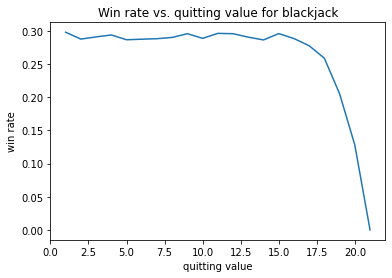

best quitting value: 1


In [107]:
# Plot here
winrates = []
enns = np.arange(1,22)
for n in enns:
	clear_output(wait = True)
	print(f'testing stopping value: {n}')
	winrates.append(blackjack(n))
plt.plot(enns, winrates)
plt.title("Win rate vs. quitting value for blackjack")
plt.xlabel("quitting value")
plt.ylabel("win rate")
plt.show()
print(f'best quitting value: {np.argmax(winrates)+1}')


*Identify which value(s) give the highest winrate here:*
n ~ 10-14

**Problem 3**

* Implement `cartpole()`.
* Render the game and run your function once.
* Run Cartpole 100 times (without rendering) and print out the average number of steps before it terminates.

In [108]:
# Problem 3
def cartpole(render=False):
    """
    Solve CartPole-v0 by checking the velocity
    of the tip of the pole.
    Parameters: 
        render (bool): If True, render environment at each step
    Return:
        iterations (integer): number of steps or iterations
                              to solve the environment
    """
    count = 0
    with gym.make("CartPole-v1") as env:
        env.reset()
        obs, reward, done, info = env.step(env.action_space.sample())
        while not done:
            if render:
                env.render()
            if obs[3] < 0:
                obs, reward, done, extra = env.step(0)
            else:
                obs, reward, done, extra = env.step(1)
            count += 1
    return count

In [109]:
# Render the game and run once here
cartpole()

224

In [110]:
# Run the game here and print average steps to termination
steps_per = []
for i in range(100):
	steps_per.append(cartpole())
print(f'average steps per game: {np.mean(steps_per)}')

average steps per game: 202.4


**Problem 4**

* Implement `car()`.
* Render the game and run your function once.
* Run MountainCar 100 times (without rendering) and print out the average number of steps before it terminates.

In [111]:
# Problem 4
def car(render=False):
    """
    Solve MountainCar-v0 by checking the position
    of the car.
    Parameters: 
        render (bool): If True, render environment at each step
    Return:
        iterations (integer): number of steps or iterations
                              to solve the environment
    """
    count = 0
    with gym.make("MountainCar-v0") as env:
        env.reset()
        obs, reward, done, info = env.step(2)
        if render:
            env.render()
        while not done:
            if obs[1] > 0:
                obs, reward, done, info = env.step(2)
            else:
                obs, reward, done, info = env.step(0)
            if render:
                env.render()
            count += 1
    return count

In [112]:
# Render the game here
car()

120

In [113]:
# Run the game here and print average steps to termination
steps_per = []
for i in range(100):
	steps_per.append(car())
print(f'average steps per game: {np.mean(steps_per)}')

average steps per game: 118.74


**Helper Function for Problem 5**

In [114]:
def find_qvalues(env,alpha=.1,gamma=.6,epsilon=.1):
    """
    Use the Q-learning algorithm to find qvalues.
    Parameters:
        env (str): environment name
        alpha (float): learning rate
        gamma (float): discount factor
        epsilon (float): maximum value
    Returns:
        q_table (ndarray nxm)
    """
    # Make environment
    env = gym.make(env)
    # Make Q-table
    q_table = np.zeros((env.observation_space.n,env.action_space.n))

    # Train
    for i in range(1,100001):
        # Reset state
        state = env.reset()

        epochs, penalties, reward, = 0,0,0
        done = False

        while not done:
            # Accept based on alpha
            if random.uniform(0,1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state])

            # Take action
            next_state, reward, done, info = env.step(action)

            # Calculate new qvalue
            old_value = q_table[state,action]
            next_max = np.max(q_table[next_state])

            new_value = (1-alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state, action] = new_value

            # Check if penalty is made
            if reward == -10:
                penalties += 1

            # Get next observation
            state = next_state
            epochs += 1

        # Print episode number
        if i % 500 == 0:
            clear_output(wait=True)
            print(f"Episode: {i}")

    print("Training finished.")
    return q_table


**Problem 5**

* Render the "`Taxi-v3`" environment, act randomly until it terminates, and calculate the total reward
* Render the "`Taxi-v3`" environment, use the Q-table to act optimally until it terminates, and calculate the total reward
* Implement `taxi()`, then use it to print the average total reward for each algorithm.


In [115]:
# Random actions Taxi game
def random_taxi():
	reward_potatoes = 0
	with gym.make("Taxi-v3") as env:
		env.reset()
		obs, reward, done, info = env.step(env.action_space.sample())
		reward_potatoes += reward
		while not done:
			obs, reward, done, info = env.step(env.action_space.sample())
			reward_potatoes += reward
	return reward_potatoes

In [116]:
# Q-table actions Taxi game
def q_taxi(qtable):
	reward_potatoes = 0 # total_reward -> tots_reward -> reward_potatoes
	with gym.make("Taxi-v3") as env:
		env.reset()
		done = False
		counter = 0
		while not done:
			move = np.argmax(qtable[i])
			obs,reward,done,info = env.step(move)
			reward_potatoes += reward
	return reward_potatoes

In [117]:
def taxi(q_table):
    """
    Compare naive and q-learning algorithms.
    Parameters:
        q_table (ndarray nxm): table of qvalues
    Returns:
        naive (float): mean reward of naive algorithm
                       of 10000 runs
        q_reward (float): mean reward of Q-learning algorithm
                          of 10000 runs
    """
    random_potatoes = []
    q_potatoes = []
    N = 10000
    for i in range(1,N+1):
        if i%100==0:
            clear_output(wait=True)
            print(f'running taxi algorithm:\n{i}', end = f"/{N} ({100*i/N:.0f}%)\n")
        random_potatoes.append(random_taxi())
        q_potatoes.append(q_taxi(q_table))
        
    return np.mean(random_potatoes), np.mean(q_potatoes)

In [118]:
qtable = find_qvalues("Taxi-v3")

Episode: 100000
Training finished.


In [119]:
# Print the average rewards of the Taxi game for both algorithms run 10,000 times
r, q = taxi(qtable)
print(f'\nrandom reward:{r}, q_table reward{q}')

running taxi algorithm:
10000/10000 (100%)

random reward:-768.6895, q_table reward-200.0
